![](https://media.discordapp.net/attachments/1047111061314220033/1176542563633737728/image.png)


_Notes :_

- Approche contre factuelle $\Rightarrow$ que faire pour que l'exemple ne soit plus un outlier ?
- Base de référence : dataset classique


# TME 8 - Détection et explication d'exceptions


## Génération d'une base artificielle


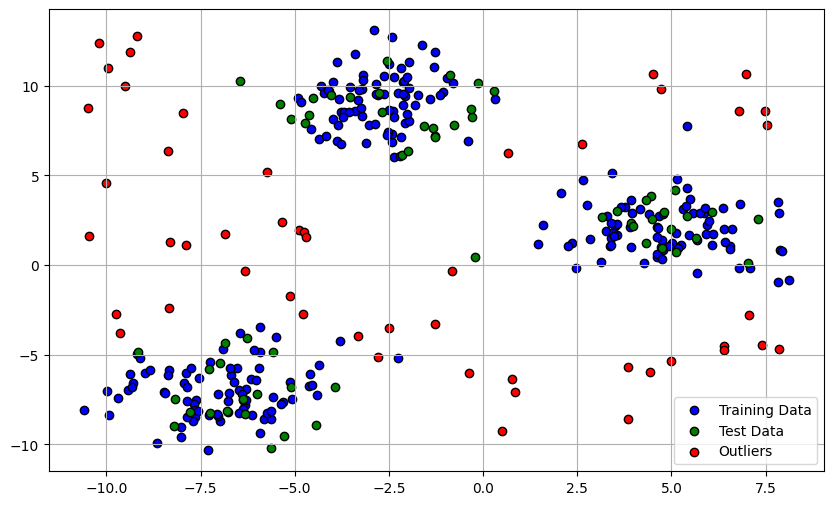

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


def generate_blobs(
    n_samples=500,
    n_clusters=3,
    cluster_std=1.0,
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles de type "blobs".

    :param n_samples: Nombre d'échantillons, defaults to 300
    :param n_clusters: Nombre de clusters, 3 par défaut.
    :param cluster_std: Ecart-type des clusters, 1.0 par défaut.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et les outliers.
    """
    rng = np.random.RandomState(random_seed)

    X, _, centers = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=n_clusters,
        cluster_std=cluster_std,
        random_state=random_seed,
        return_centers=True,
    )

    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


def generate_outliers(X, centers, n_outliers=50, min_distance=4, random_seed=42):
    """Génère des outliers, c'est-à-dire des points qui sont en dehors des clusters
    générés. Le plus simple serait de généré aléatoirement des outliers sur l'ensemble
    de la grille, mais cela résulterait en des outliers faisant potentiellement partie
    de clusters, biaisant alors notre détecteur.

    :param X: Clusters.
    :param centers: Centres des clusters.
    :param n_outliers: Nombre d'outliers, defaults to 50
    :param min_distance: Distance euclidienneminimale entre les clusters et les outliers,
    4 est une bonne valeur minimisant le nombre d'outliers pouvant apparaître dans les
    clusters tout en leur laissant la possibilité d'être proche.
    :param random_seed: Graine aléatoire pour la reproducibilité.
    :return: Un ensemble d'outliers.
    """
    rng = np.random.RandomState(random_seed)
    # Générer des outliers
    X_outliers = []
    while len(X_outliers) < n_outliers:
        outlier_candidate = rng.uniform(X.min(axis=0), X.max(axis=0), X.shape[1])
        # Est-ce que le candidat est un outlier, c.-à-d. ne fait-il pas partie d'un cluster ?
        if np.all(
            np.min(np.linalg.norm(centers - outlier_candidate, axis=1)) >= min_distance
        ):
            X_outliers.append(outlier_candidate)
    return np.array(X_outliers)


def plot_data(X_train, X_test, X_outliers):
    """Affiche les données artificiellement générées."""
    plt.figure(figsize=(10, 6))
    # Plot les données d'entraînement
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c="blue", label="Training Data", edgecolors="k"
    )
    # Plot les données de test
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c="green", label="Test Data", edgecolors="k"
    )
    # Plot les outliers
    plt.scatter(
        X_outliers[:, 0], X_outliers[:, 1], c="red", label="Outliers", edgecolors="k"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, X_test, X_outliers = generate_blobs(
    n_samples=300, n_clusters=3, cluster_std=1.5, n_outliers=50
)
plot_data(X_train, X_test, X_outliers)

## Détection d'exceptions

Avec Scikit-learn, il existe deux méthodes possibles :

- **Outlier detection** : approche supervisée, les données contiennent les outliers.
- **Novelty detection** : approche non supervisée, les données ne contiennent pas les outliers.

La différence majeure concerne le LOF, qui a été désigné spécifiquement pour de l'outlier detection. Dans ce mode de détection, LOF ne contient qu'une méthode `fit_predict` : il est **impossible** d'obtenir les frontières de décision. On peut seulement obtenir les scores : plus le score est grand, plus l'observation est un outlier.

Pour le One-Class SVM et la forêt d'isolation, la construction du classifieur ne change pas.


In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


def train_lof(X_train, mode, n_neighbors=20, contamination="auto"):
    """Entraine un Local Outlier Factor.

    Outlier detection si mode=False, novelty detection si mode=True.
    """
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, novelty=mode, contamination=contamination
    )
    if mode:
        clf.fit(X_train)
    return clf


def train_one_class_svm(X_train, nu=0.5, gamma="auto"):
    """Entraine un One-Class SVM."""
    clf = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
    clf.fit(X_train)
    return clf


def train_isolation_forest(
    X_train, n_estimators=100, contamination="auto", random_state=0
):
    """Entraine un Isolation Forest."""
    clf = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=random_state,
    )
    clf.fit(X_train)
    return clf

### Outlier detection


In [3]:
def plot_decision_boundary_outlier(clf, X, X_outliers, title):
    """Affiche les frontières de décision d'un classifieur."""
    plt.figure(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh_samples = np.c_[xx.ravel(), yy.ravel()]

    if clf.__class__.__name__ == "LocalOutlierFactor":
        y_pred = clf.fit_predict(X)
        Z = clf.negative_outlier_factor_
        radius = (Z.max() - Z) / (Z.max() - Z.min())
        plt.scatter(
            X[:, 0],
            X[:, 1],
            s=1000 * radius,
            edgecolor="firebrick",
            facecolors="none",
            label="Outliers scores",
        )
    else:
        y_pred = clf.predict(X)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(mesh_samples)
        else:
            Z = clf.predict(mesh_samples)

        Z = Z.reshape(xx.shape)
        contour = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
        cbar = plt.colorbar(contour)
        cbar.set_label("Decision Function Value")

    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c="blueviolet", edgecolor="k", s=20, label="Obs.")

    # Plot outliers
    plt.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="r",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize="x-small")

    ground_truth = np.ones(len(X), dtype=int)
    ground_truth[-len(X_outliers) :] = -1
    n_errors = (y_pred != ground_truth).sum()
    plt.xlabel(f"errors: {n_errors}/{X.shape[0]}")

    plt.show()

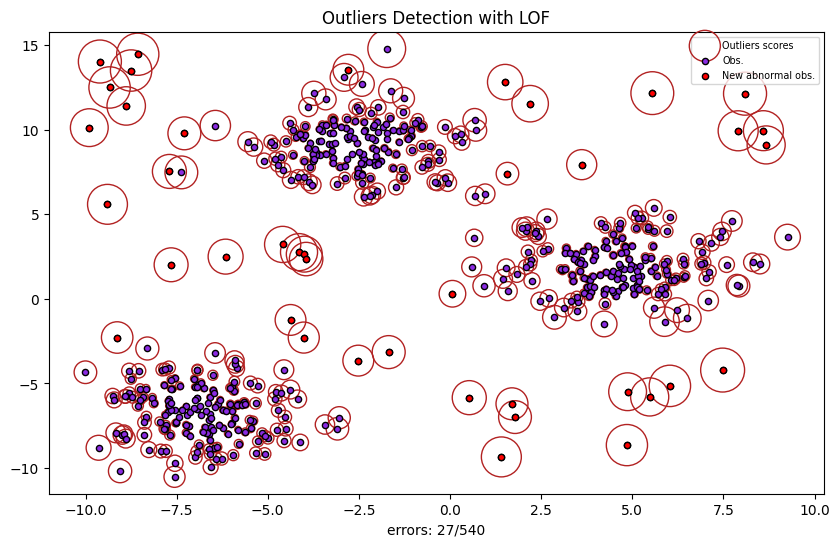

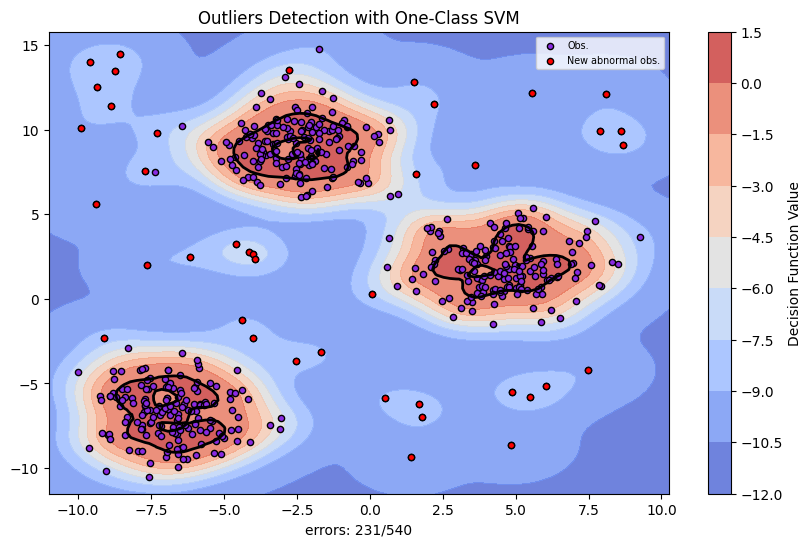

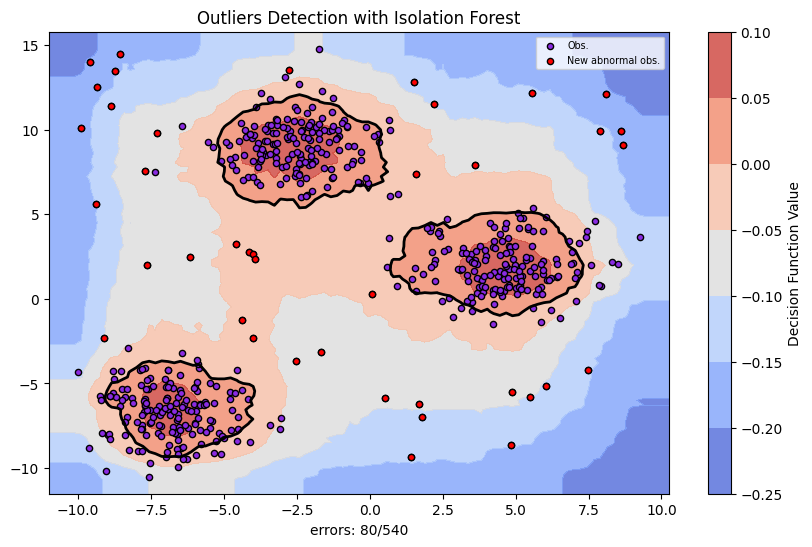

In [4]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)
X = np.vstack((X_train, X_test, X_outliers))
# Entraîner chaque modèle
lof_clf = train_lof(X, mode=False)
svm_clf = train_one_class_svm(X)
iso_forest_clf = train_isolation_forest(X)

# Visualize decision boundaries for each model
plot_decision_boundary_outlier(lof_clf, X, X_outliers, "Outliers Detection with LOF")
plot_decision_boundary_outlier(
    svm_clf, X, X_outliers, "Outliers Detection with One-Class SVM"
)
plot_decision_boundary_outlier(
    iso_forest_clf,
    X,
    X_outliers,
    "Outliers Detection with Isolation Forest",
)

### Novelty detection


In [5]:
def plot_decision_boundary_novelty(clf, X, X_test, X_outliers, title):
    """Affiche les frontières de décision d'un classifieur."""
    plt.figure(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = (
        min(X[:, 0].min(), X_outliers[:, 0].min()) - 1,
        max(X[:, 0].max(), X_outliers[:, 0].max()) + 1,
    )
    y_min, y_max = (
        min(X[:, 1].min(), X_outliers[:, 1].min()) - 1,
        max(X[:, 1].max(), X_outliers[:, 1].max()) + 1,
    )
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Plot decision boundary
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    contour = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
    # Add a colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label("Decision Function Value")

    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c="white", edgecolor="k", s=20, label="Training obs.")

    # Plot test points
    plt.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c="blueviolet",
        edgecolor="k",
        s=20,
        label="New regular obs.",
    )

    # Plot outliers
    plt.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="red",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize="x-small")

    # Statistics
    y_pred_train = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    plt.xlabel(
        "error train: %d/%d; errors novel regular: %d/%d; errors novel abnormal: %d/%d"
        % (
            n_error_train,
            X.shape[0],
            n_error_test,
            X_test.shape[0],
            n_error_outliers,
            X_outliers.shape[0],
        )
    )
    plt.show()

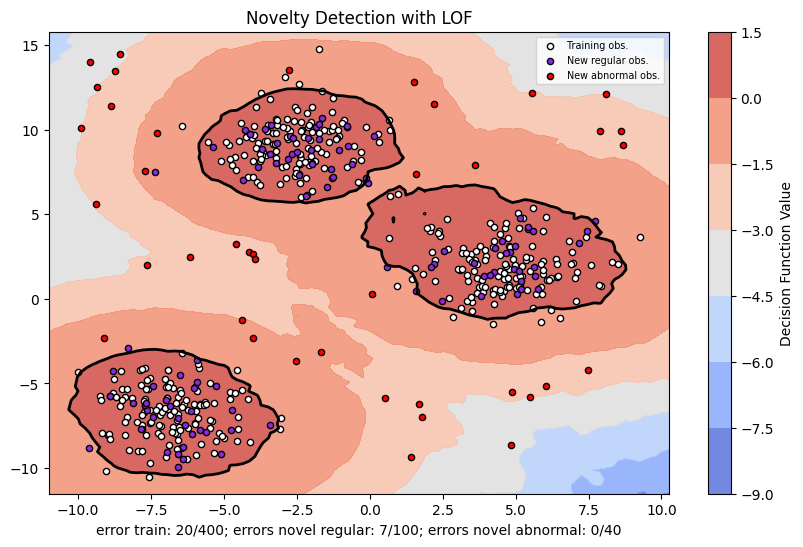

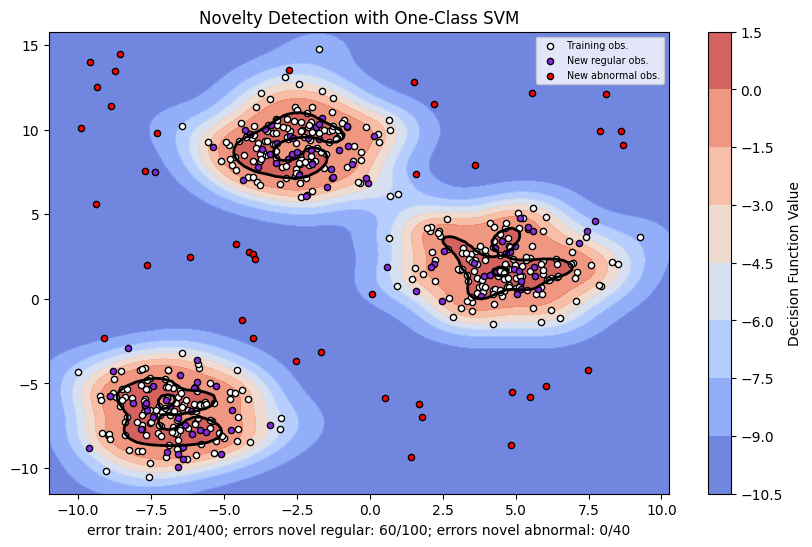

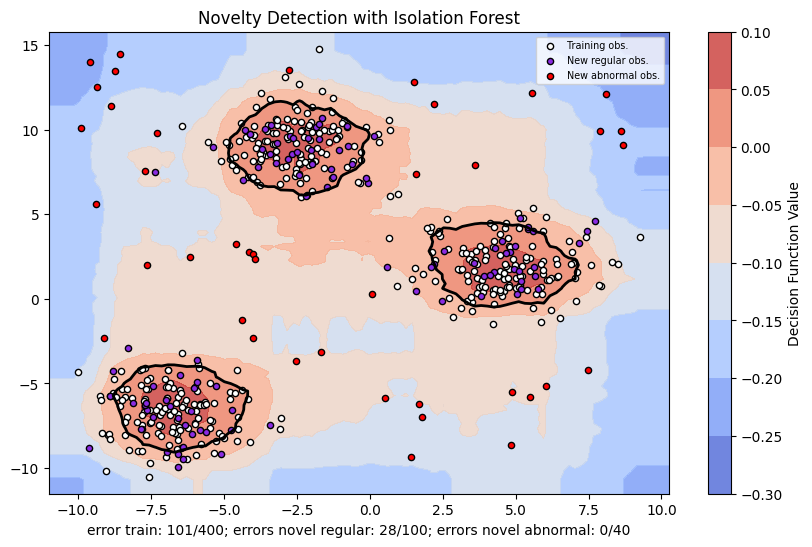

In [6]:
# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, "Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf, X_train, X_test, X_outliers, "Novelty Detection with One-Class SVM"
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    "Novelty Detection with Isolation Forest",
)

Permet d'avoir des résultats beaucoup plus visuels mais pas forcément adaptés pour la suite pour notre travail de réflexion sur LOF.


J'aimerais bien avoir des données plus "allongées", comme dans le cours.

$\Rightarrow$ Loi normale multidimensionnelle : $\mathcal{N}(\mu, \Sigma)$ où $\mu \in \mathbb{R}^N$ représente le centre et $\Sigma \in \mathcal{M}_N(\mathbb{R})$ est sa matrice de covariance, $N$ étant la dimension de nos données (2 car nous travaillons en 2D).


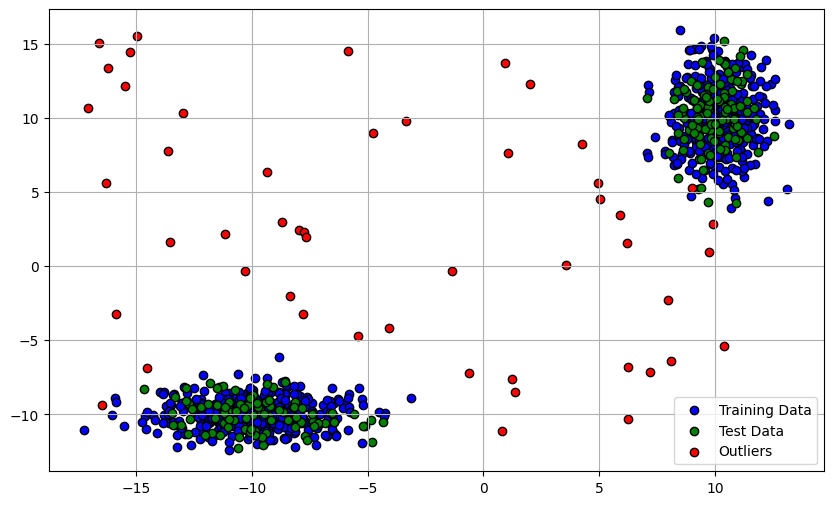

In [7]:
def generate_elongated(
    n_samples=1000,
    n_clusters=2,
    centers=[(-10, -10), (10, 10)],
    cov=[np.array([[5, 0], [0, 1]]), np.array([[1, 0], [0, 5]])],
    n_outliers=50,
    random_seed=42,
):
    """Génère des données artificielles de "allongées", c.à-d. des distributions
    normales multidimensionnelles.

    :param n_samples: Nombre d'échantillons, defaults to 300
    :param n_clusters: Nombre de clusters, 2 par défaut.
    :param centers: Les centres pour chaque cluster.
    :param cov: Les matrices de covariance pour chaque cluster.
    :param n_outliers: Nombre d'outliers, 50 par défaut.
    :param random_seed: Graine aléatoire, 42 par défaut.
    :return: Un ensemble de train, de test et les outliers.
    """
    assert len(centers) == n_clusters, ValueError(
        f"Number of centers {len(centers)} must match number of clusters {n_clusters}"
    )
    assert len(cov) == n_clusters, ValueError(
        f"Number of covariance matrixes {len(centers)} must match number of clusters {n_clusters}"
    )

    rng = np.random.RandomState(random_seed)

    # Génération de distributions normales multidimensionnelles
    X = np.empty((0, 2))

    for cluster in range(n_clusters):
        X_cluster = rng.multivariate_normal(
            centers[cluster], cov[cluster], n_samples // n_clusters
        )
        X = np.vstack([X, X_cluster])

    # Générer des outliers
    X_outliers = generate_outliers(
        X, centers, n_outliers=n_outliers, random_seed=random_seed
    )

    # Séparer les données en ensembles d'entraînement et de test
    rng.shuffle(X)
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, np.array(X_outliers)


X_train, X_test, X_outliers = generate_elongated()
plot_data(X_train, X_test, X_outliers)

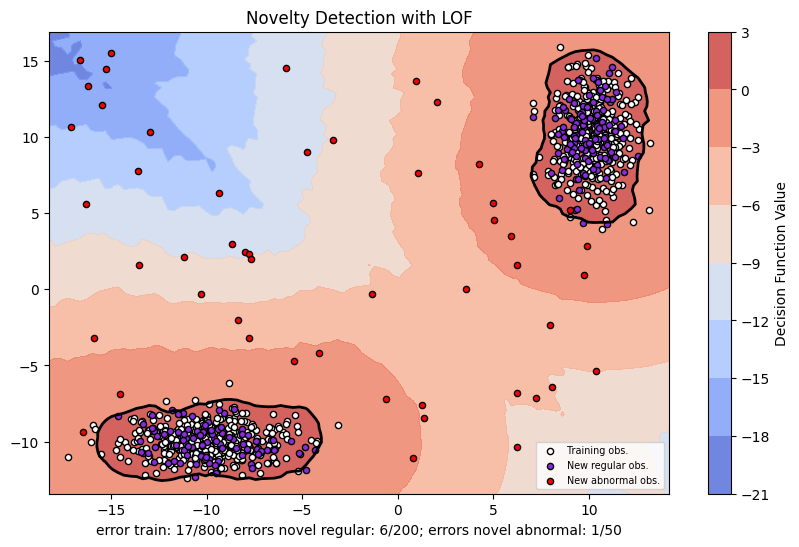

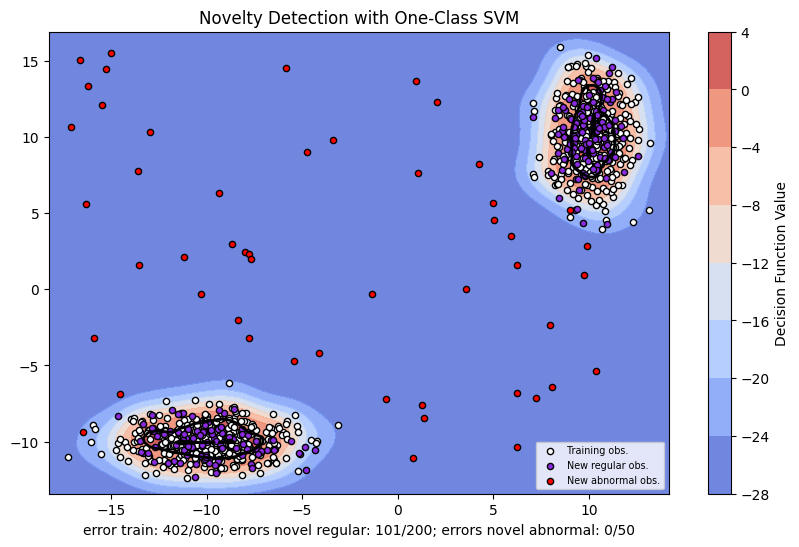

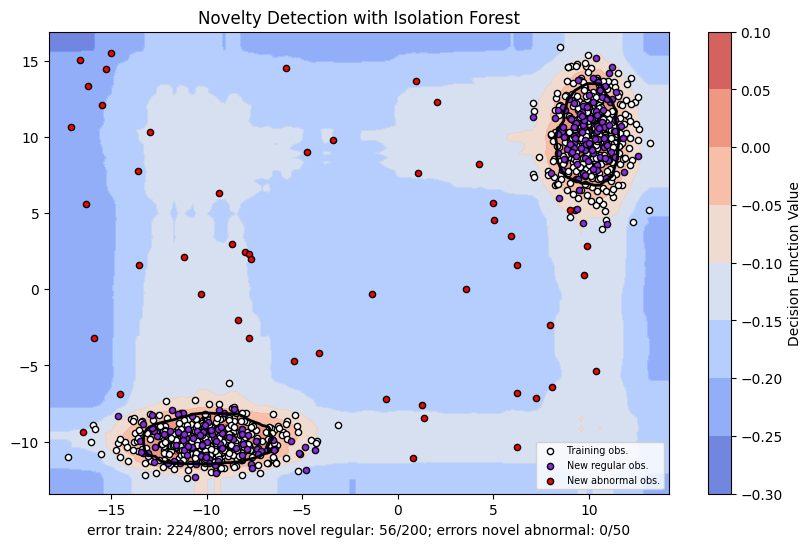

In [8]:
# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, "Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf, X_train, X_test, X_outliers, "Novelty Detection with One-Class SVM"
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    "Novelty Detection with Isolation Forest",
)

Très content.

$\Rightarrow$ Combiner blobs et distributions normales multidimensionnelles ??


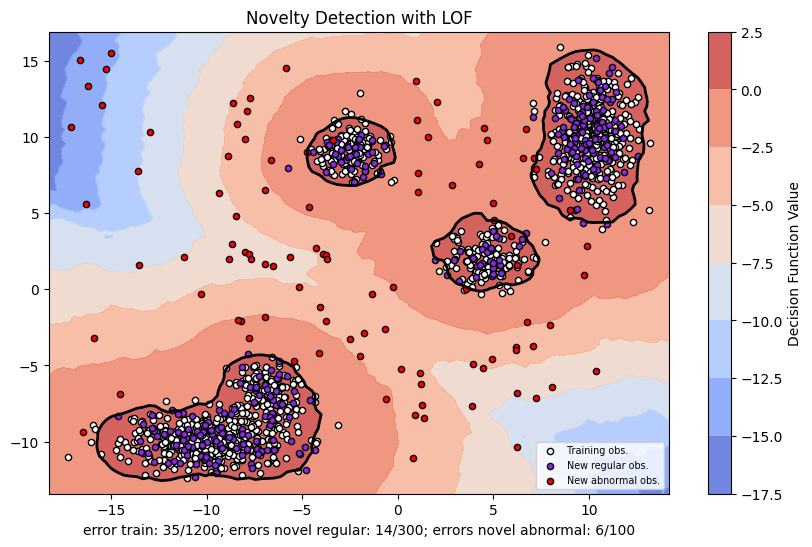

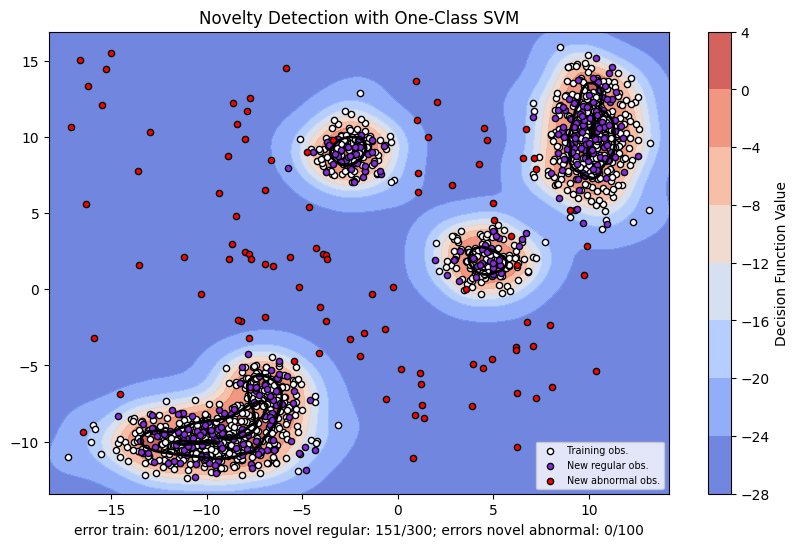

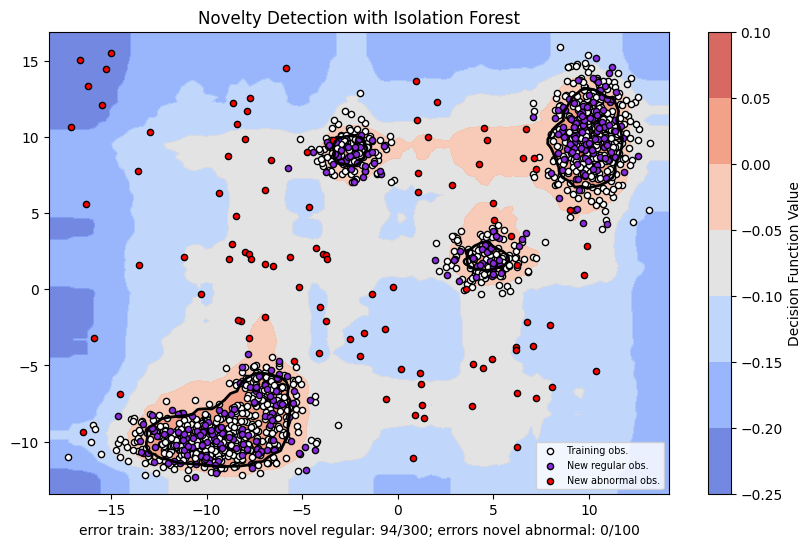

In [9]:
X_blobs_train, X_blobs_test, X_blobs_outliers = generate_blobs()
X_elongated_train, X_elongated_test, X_elongated_outliers = generate_elongated()

X_train = np.vstack((X_blobs_train, X_elongated_train))
X_test = np.vstack((X_blobs_test, X_elongated_test))
X_outliers = np.vstack((X_blobs_outliers, X_elongated_outliers))

# Entraîner chaque modèle
lof_clf = train_lof(X_train, mode=True)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary_novelty(
    lof_clf, X_train, X_test, X_outliers, "Novelty Detection with LOF"
)
plot_decision_boundary_novelty(
    svm_clf, X_train, X_test, X_outliers, "Novelty Detection with One-Class SVM"
)
plot_decision_boundary_novelty(
    iso_forest_clf,
    X_train,
    X_test,
    X_outliers,
    "Novelty Detection with Isolation Forest",
)

Bref, ça marche bien, on peut générer des données plus ou moins complexes maintenant. :)

Néanmois, ces trois expérimentaitons sur trois types de données artificielles différentes nous renvoient des _insights_ intéressants :

- **LOF :** Les frontières de décision est **ajustée autour du noyau des clusters**, qui est caractéristique du LOF (sensible à la densité locale des points de données). Il identifie les valeurs aberrantes comme des points dont la densité est nettement inférieure à celle de leurs voisins. LOF est assez précis dans l'identification des régions denses des données, mais il peut avoir des difficultés avec les points de données qui se trouvent dans les régions peu denses entre les clusters. Néanmoins, c'est celui qui performe le mieux.

- **One-Class SVM :** Les frontières de décision sont plus lisses (car noyau RBF) et englobent les clusters. Ce modèle tend à créer une frontière qui tente de conserver les points de données normaux tout en excluant les valeurs aberrantes. Le graphique montre une frontière **étroite autour des clusters**, mais aussi plusieurs petites limites circulaires.

- **Forêt d'isolation :** Les frontières de décision sont **irrégulières**, caractéristique des arbres de décision qui cherche à isoler les exceptions. Le graphique suggère que la forêt d'isolation est moins influencée par la distribution sous-jacente des données que par leur structure. Elle effectue un partitionnement qui peut aboutir à des régions de valeurs aberrantes plus grandes, ce qui peut être bénéfique pour les ensembles de données présentant des structures complexes.


## Explication naïve


Mais pourquoi le classifieur prédit cette donnée comme exceptionnelle (ou non) ?

Pour expliquer cette prédiction, examinons d'abord les explications naïves que nous pouvons générer pour des classifieurs tels que LOF, SVM ou les arbres de décision lorsqu'ils évaluent une observation donnée, notée $x$, pour déterminer si elle est exceptionnelle ou non L'excplication mettra en évidence les modifications nécessaires pour que cette prédiction ne soit plus considérée comme une exception ou non.

Quelques pistes :

- LOF (Local Outlier Factor) : Lorsque le LOF attribue une valeur très élevée à une donnée, cela signifie qu'elle est très exceptionnelle. Nous devons donc nous demander si les modifications nécessaires pour expliquer cette prédiction sont plus importantes que celles nécessaires pour un LOF moyen. Existe-t-il une corrélation entre la valeur du LOF et l'ampleur des modifications suggérées par cette explication naïve ?

- Forêt d'isolation : Contrairement au LOF, la forêt d'isolation fonctionne selon un principe différent, ce qui signifie qu'il n'y a pas nécessairement de corrélation directe avec le LOF. Par conséquent, la raison sous-jacente à la prédiction d'exceptionnalité dans ce cas devrait différer de celle fournie par le LOF. Il peut être nécessaire d'utiliser des méthodes spécifiques pour les forêts, comme DIFFI (voir p.26).

Pour des explications plus sophistiquées ("moins naïves"), nous pouvons également considérer l'approche LIME, qui se penche sur les attributs importants dans la prise de décision du classifieur. Quels attributs sont déterminants pour que cette donnée soit considérée comme exceptionnelle par le modèle ?

Il existe également d'autres algorithmes pour l'importance d'attribut (p. 25-26 du cours) : [LookOut](https://github.com/xuhongzuo/outlier-interpretation), [DIFFI](https://github.com/mattiacarletti/DIFFI), [KernelSHAP](https://github.com/ronniemi/explainAnomaliesUsingSHAP)...


### Contrefactuel sur les forêts d'isolation


#### DiceML


In [ ]:
import dice_ml
import warnings
import pandas as pd


def visualize(
    X,  # les données
    # y=None,
    clf,
    backend="sklearn",
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

    # if not clf and not y:
    #     y = clf.fit_predict(X)
    y = clf.fit_predict(X)

    df = pd.DataFrame(X, columns=["X", "Y"])
    df["Target"] = y

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["X", "Y"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["X", "Y"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    first_outliers = np.argwhere(y == 1)[0]
    ax.scatter(
        df.loc[first_outliers, "X"],
        df.loc[first_outliers, "Y"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return enemy_df


class CustomIsolationForest(IsolationForest):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict_proba(self, X):
        return super().score_samples(X)


clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.predict_proba = lambda x: clf.score_samples(x)
visualize(X_similar, clf=clf)
# for name, clf in anomaly_algorithms:
# fig = plt.figure(figsize=(27, 6))
# for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
#     X, y = dataset
#     clf = clf.fit(X, y)
#     ax = fig.add_subplot(1, len(datasets), i + 1)
#     ax.set_title(name)
#     visualize(X, y, clf, "sklearn", ax=ax)
# fig.tight_layout()

#### Growing Spheres


In [9]:
from sklearn.inspection import DecisionBoundaryDisplay

#   ┌────────────────────────────────────────────────────────────────────────┐
#   │ Plot                                                                   │
#   └────────────────────────────────────────────────────────────────────────┘


def plot_boundaries(X, y, ax, clf):
    """Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_obs_and_enemy(obs, enemy, ax, colors=["red", "orange"]):
    """
    Plot the observation to interprete and the enemy returned by the growing sphere
    generation algorithm.
    """
    ax.scatter(*enemy, c=colors[0])
    ax.scatter(*obs, c=colors[1])


#    ┌────────────────────────────────────────────────────────────────────────┐
#    │ Growing Spheres                                                        │
#    └────────────────────────────────────────────────────────────────────────┘


class GrowingSpheres:
    """
    obs_to_interprete : x, une observation à interpréter
    clf : classifieur binaire
    eta : hyperparamètre
    n : nombre de points que l'on génère
    """

    def __init__(self, clf, eta, n):
        self.clf = clf
        self.eta = eta
        self.n = n

    def generate_spherical_layer(self, a0, a1) -> np.ndarray:
        """
        Generate a spherical layer with the specified parameters.

        Parameters:
            a0 (float): Inner radius of the spherical layer.
            a1 (float): Outer radius of the spherical layer.

        Returns:
            np.ndarray: A numpy array representing the generated spherical layer.
        """

        def norm(v):
            return np.linalg.norm(v, ord=2, axis=1)

        z = np.random.normal(0, 1, (self.n, self.d))
        u = np.random.uniform(a0**self.d, a1**self.d, size=self.n)
        u = u ** (1 / self.d)
        z = np.array(
            [a * b / c for a, b, c in zip(z, u, norm(z))]
        )  # z = z * u / norm(z)
        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer):
        """
        Find and update enemy information in a spherical layer.

        Parameters:
            spherical_layer (numpy.ndarray): A 2D numpy array representing the spherical
            layer data.

        Returns:
            bool: True if enemies are found in the spherical layer, False otherwise.
        """
        pred = self.clf.predict(spherical_layer)
        self.enemies = spherical_layer[pred != self.obs_predict]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = obs_to_interprete.reshape(1, -1)
        self.obs_predict = self.clf.predict(self.obs_to_interprete)
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy, self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[
            np.linalg.norm(self.enemies - self.obs_to_interprete).argmin()
        ]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.flatten())),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.copy()
        reduced = 0

        for k in move_sorted:
            new_enn = out.copy()
            new_enn[k] = self.obs_to_interprete.flatten()[k]

            if self.clf.predict(new_enn.reshape(1, -1)) == self.obs_predict:
                out[k] = new_enn[k]
                reduced += 1

        return out


def find_enemies(dataset, clf, obs_to_interpret, n=10, eta=2, n_gs=100):
    X, y = dataset
    clf.fit(X, y)

    enemies = []
    enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        enemies_fs.append(enemy_fs)

    return enemies, enemies_fs


def visualize(X, y, clf, obs_to_interprete, n=10, eta=2, n_gs=100, ax=None):
    enemies, enemies_fs = find_enemies((X, y), clf, obs_to_interprete, n, eta, n_gs)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker="o", label="Obs", s=100)

    for enemy, _ in zip(enemies[:-1], enemies_fs[:-1]):
        ax.scatter(*enemy, c="blue", marker="x", s=100)
        # ax.scatter(*enemy_fs, c="orange", marker="x", s=100)
    ax.scatter(*enemies[-1], c="blue", marker="x", label="Enemy", s=100)
    # ax.scatter(*enemies_fs[-1], c="orange", marker="x", label="Enemy Feature Selection", s=100)
    ax.legend()
    return ax

<Axes: >

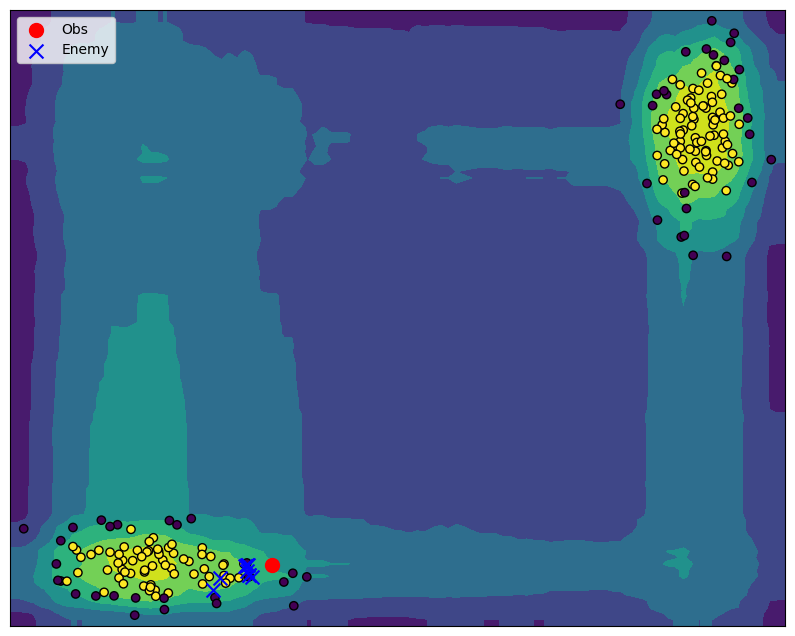

In [17]:
X, X_test, X_outliers = generate_elongated()
iso_forest_clf = train_isolation_forest(X)
y_pred = iso_forest_clf.predict(X_test)

idx = np.argwhere(y_pred == -1)[40]  # first outliers
obs = X_test[idx][0]

radius = 0.5
step = 0.5
N = 300

GS = GrowingSpheres(iso_forest_clf, 2, N)
GS.predict(obs)
SL = GS.generate_spherical_layer(radius, radius + step)

fig, ax = plt.subplots(figsize=(10, 8))
visualize(X_test, y_pred, iso_forest_clf, obs, ax=ax)

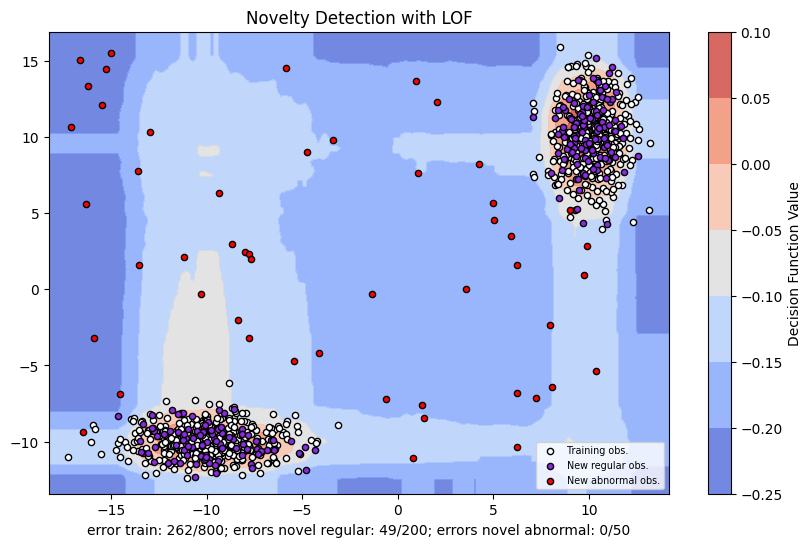

In [19]:
# TODO: adapter code pour utiliser celle-là ?

plot_decision_boundary_novelty(
    iso_forest_clf, X, X_test, X_outliers, "Novelty Detection with LOF"
)